In [ ]:
#Importing Necessary libraries
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [ ]:
# Seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [ ]:
NUM_WORDS = 10000
MAXLEN = 150
VALIDATION_SAMPLES = 10000
DEFAULT_TRAIN_SAMPLES = 100
EMBEDDING_DIM = 100      # embedding dimension
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
# Load IMDB dataset
(x_train_all, y_train_all), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

print("Full train size:", len(x_train_all))
print("Test size:", len(x_test))

# Pad sequences to MAXLEN
x_train_all = keras.preprocessing.sequence.pad_sequences(x_train_all, maxlen=MAXLEN, truncating='post', padding='post')
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=MAXLEN, truncating='post', padding='post')
print("Shapes after padding:", x_train_all.shape, x_test.shape)


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Full train size: 25000
Test size: 25000
Shapes after padding: (25000, 150) (25000, 150)


In [ ]:
# Validation Split
x_val = x_test[:VALIDATION_SAMPLES]
y_val = y_test[:VALIDATION_SAMPLES]

# Final evaluation
x_test_rem = x_test[VALIDATION_SAMPLES:]
y_test_rem = y_test[VALIDATION_SAMPLES:]

print("Validation shape:", x_val.shape, y_val.shape)
print("Remaining test shape:", x_test_rem.shape)


Validation shape: (10000, 150) (10000,)
Remaining test shape: (15000, 150)


In [ ]:
# trainable model
def build_trainable_embedding_model(num_words=NUM_WORDS, embedding_dim=EMBEDDING_DIM, maxlen=MAXLEN):
    inp = layers.Input(shape=(maxlen,), dtype='int32')
    x = layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxlen, name='trainable_embedding')(inp)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
#pre-trained model
def download_glove_if_needed(target_dir='glove'):

    os.makedirs(target_dir, exist_ok=True)
    glove_txt = os.path.join(target_dir, 'glove.6B.100d.txt')
    if not os.path.exists(glove_txt):
        print("GloVe file not found locally. Attempting to download (will take ~tens of MB)...")
        # Use Keras utility to download
        zip_url = 'http://nlp.stanford.edu/data/glove.6B.zip'
        zip_path = os.path.join(target_dir, 'glove.6B.zip')
        try:
            # stream download
            import urllib.request
            urllib.request.urlretrieve(zip_url, zip_path)
            import zipfile
            with zipfile.ZipFile(zip_path, 'r') as z:
                z.extract('glove.6B.100d.txt', path=target_dir)
            os.remove(zip_path)
            print("Downloaded and extracted GloVe 100d.")
        except Exception as e:
            print("Automatic download failed. Please download glove.6B.100d.txt from "
                  "http://nlp.stanford.edu/data/glove.6B.zip, extract, and put glove.6B.100d.txt in", target_dir)
            raise

    return glove_txt

def build_pretrained_embedding_model(word_index, num_words=NUM_WORDS, embedding_dim=EMBEDDING_DIM, maxlen=MAXLEN):
    glove_path = download_glove_if_needed()
    # Load glove into a dict
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.rstrip().split(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs


    index_word = {v: k for k, v in keras.datasets.imdb.get_word_index().items()}

    embedding_matrix = np.zeros((num_words, embedding_dim))
    for i in range(1, num_words):
        word = index_word.get(i - 3)
        if word is None:
            # direct mapping:
            word = index_word.get(i)
        if not word:
            continue
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[i] = vec

    inp = layers.Input(shape=(maxlen,), dtype='int32')
    emb_layer = layers.Embedding(input_dim=num_words,
                                 output_dim=embedding_dim,
                                 weights=[embedding_matrix],
                                 input_length=maxlen,
                                 trainable=False,
                                 name='glove_embedding')
    x = emb_layer(inp)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:

def get_train_slice(x_all, y_all, n_samples=DEFAULT_TRAIN_SAMPLES):
    n = min(n_samples, x_all.shape[0])
    return x_all[:n], y_all[:n]


x_small, y_small = get_train_slice(x_train_all, np.array(y_train_all), 100)
print("Small train slice shape:", x_small.shape)


Small train slice shape: (100, 150)


In [ ]:
# Train both models (trainable embedding vs pretrained) on the small training set
def train_and_evaluate(train_samples=DEFAULT_TRAIN_SAMPLES, epochs=EPOCHS, verbose=1):
    x_train, y_train = get_train_slice(x_train_all, np.array(y_train_all), train_samples)

    print(f"\nTraining with {train_samples} samples | epochs={epochs}\n")

    # Model A: trainable embedding
    model_a = build_trainable_embedding_model()
    history_a = model_a.fit(x_train, y_train,
                            validation_data=(x_val, y_val),
                            epochs=epochs, batch_size=BATCH_SIZE, verbose=verbose)

    # Model B: pretrained GloVe embedding
    model_b = build_pretrained_embedding_model(keras.datasets.imdb.get_word_index())
    history_b = model_b.fit(x_train, y_train,
                            validation_data=(x_val, y_val),
                            epochs=epochs, batch_size=BATCH_SIZE, verbose=verbose)

    # Evaluate on remaining test set
    eval_a = model_a.evaluate(x_test_rem, y_test_rem, verbose=0) if x_test_rem.shape[0] else (None, None)
    eval_b = model_b.evaluate(x_test_rem, y_test_rem, verbose=0) if x_test_rem.shape[0] else (None, None)

    results = {
        'model_a': {'model': model_a, 'history': history_a.history, 'test_eval': eval_a},
        'model_b': {'model': model_b, 'history': history_b.history, 'test_eval': eval_b}
    }
    return results


In [ ]:
# Run the primary experiment with train_samples=100
results_small = train_and_evaluate(train_samples=100, epochs=5, verbose=2)




Training with 100 samples | epochs=5



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
4/4 - 8s - 2s/step - accuracy: 0.5500 - loss: 0.6930 - val_accuracy: 0.5027 - val_loss: 0.6932
Epoch 2/5
4/4 - 2s - 484ms/step - accuracy: 0.5900 - loss: 0.6880 - val_accuracy: 0.5027 - val_loss: 0.6939
Epoch 3/5
4/4 - 2s - 495ms/step - accuracy: 0.5800 - loss: 0.6803 - val_accuracy: 0.5027 - val_loss: 0.6963
Epoch 4/5
4/4 - 3s - 684ms/step - accuracy: 0.5800 - loss: 0.6694 - val_accuracy: 0.5027 - val_loss: 0.7014
Epoch 5/5
4/4 - 2s - 491ms/step - accuracy: 0.5800 - loss: 0.6559 - val_accuracy: 0.5027 - val_loss: 0.7112
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
GloVe file not found locally. Attempting to download (will take ~tens of MB)...
Downloaded and extracted GloVe 100d.
Epoch 1/5
4/4 - 4s - 1s/step - accuracy: 0.5100 - loss: 0.6993 - val_accuracy: 0.5027 - val_loss: 0.7083
Epoch 2/5
4/4 - 2s - 483ms/step - accuracy: 0.5700 - loss: 0.6706 - val_accuracy: 0.5027 - val_loss: 0.7309
Epoch 3/5
4/4 - 3s - 657ms/step - accuracy: 0.5800 - loss: 0.6751 - val_accuracy: 0.

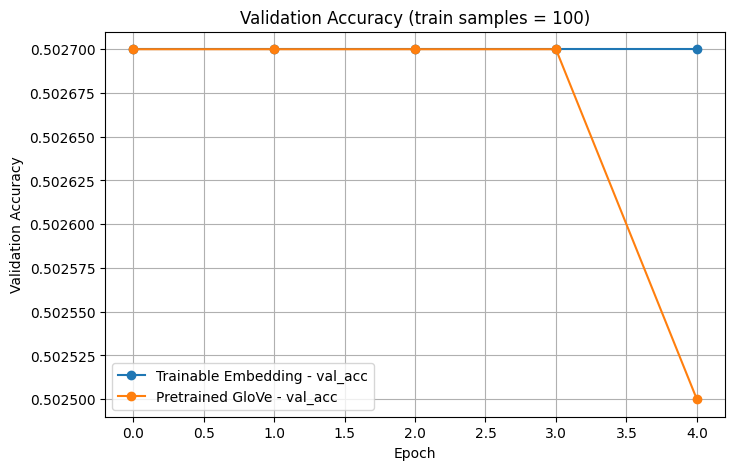


Training with 500 samples | epochs=6

Epoch 1/6
16/16 - 4s - 277ms/step - accuracy: 0.4820 - loss: 0.6939 - val_accuracy: 0.5190 - val_loss: 0.6927
Epoch 2/6
16/16 - 2s - 133ms/step - accuracy: 0.6440 - loss: 0.6862 - val_accuracy: 0.5367 - val_loss: 0.6905
Epoch 3/6
16/16 - 2s - 130ms/step - accuracy: 0.7600 - loss: 0.6023 - val_accuracy: 0.5561 - val_loss: 0.6859
Epoch 4/6
16/16 - 3s - 174ms/step - accuracy: 0.8540 - loss: 0.3898 - val_accuracy: 0.6042 - val_loss: 0.7728
Epoch 5/6
16/16 - 2s - 135ms/step - accuracy: 0.9260 - loss: 0.2241 - val_accuracy: 0.6495 - val_loss: 0.9085
Epoch 6/6
16/16 - 2s - 131ms/step - accuracy: 0.9840 - loss: 0.0439 - val_accuracy: 0.6344 - val_loss: 1.3005
Epoch 1/6
16/16 - 4s - 269ms/step - accuracy: 0.4760 - loss: 0.7079 - val_accuracy: 0.5004 - val_loss: 0.6932
Epoch 2/6
16/16 - 2s - 130ms/step - accuracy: 0.5200 - loss: 0.6991 - val_accuracy: 0.5302 - val_loss: 0.6903
Epoch 3/6
16/16 - 2s - 129ms/step - accuracy: 0.5020 - loss: 0.6906 - val_accurac

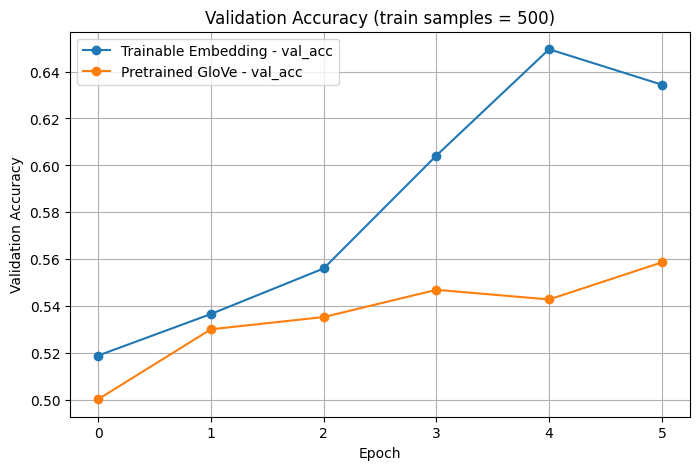

In [ ]:
# Plot validation accuracy for both models
def plot_histories(hist_a, hist_b, title_suffix='(train samples = 100)'):
    plt.figure(figsize=(8,5))
    plt.plot(hist_a['val_accuracy'], marker='o', label='Trainable Embedding - val_acc')
    plt.plot(hist_b['val_accuracy'], marker='o', label='Pretrained GloVe - val_acc')
    plt.title('Validation Accuracy ' + title_suffix)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_histories(results_small['model_a']['history'], results_small['model_b']['history'],
               title_suffix=f'(train samples = {DEFAULT_TRAIN_SAMPLES})')

# Experiment with 500 training samples
results_500 = train_and_evaluate(train_samples=500, epochs=6, verbose=2)

# Plot validation accuracy for 500-sample experiment
plot_histories(results_500['model_a']['history'],
               results_500['model_b']['history'],
               title_suffix='(train samples = 500)')


In [ ]:
def sweep_training_sizes(sizes=[50, 100, 200, 500, 1000], epochs=4):
    sweep_results = []
    for n in sizes:
        print("\n" + "-"*60)
        print(f"Sweeping: training with {n} samples")

        res = train_and_evaluate(train_samples=n, epochs=epochs, verbose=0)
        val_acc_a = res['model_a']['history']['val_accuracy'][-1]
        val_acc_b = res['model_b']['history']['val_accuracy'][-1]
        sweep_results.append({'n': n, 'val_acc_a': val_acc_a, 'val_acc_b': val_acc_b})
        print(f"n={n} | trainable val_acc={val_acc_a:.4f} | pretrained val_acc={val_acc_b:.4f}")
    return sweep_results

sizes_to_try = [50, 100, 200]
sweep_results = sweep_training_sizes(sizes=sizes_to_try, epochs=4)
print("\nSweep summary:")
for r in sweep_results:
    print(r)



------------------------------------------------------------
Sweeping: training with 50 samples

Training with 50 samples | epochs=4

n=50 | trainable val_acc=0.5027 | pretrained val_acc=0.5028

------------------------------------------------------------
Sweeping: training with 100 samples

Training with 100 samples | epochs=4

n=100 | trainable val_acc=0.5027 | pretrained val_acc=0.5028

------------------------------------------------------------
Sweeping: training with 200 samples

Training with 200 samples | epochs=4

n=200 | trainable val_acc=0.5309 | pretrained val_acc=0.5157

Sweep summary:
{'n': 50, 'val_acc_a': 0.5026999711990356, 'val_acc_b': 0.5027999877929688}
{'n': 100, 'val_acc_a': 0.5026999711990356, 'val_acc_b': 0.5027999877929688}
{'n': 200, 'val_acc_a': 0.5309000015258789, 'val_acc_b': 0.5156999826431274}


In [ ]:
report_lines = [
    "IMDB RNN Embedding vs Pretrained GloVe - Quick Report",
    f"NUM_WORDS={NUM_WORDS}, MAXLEN={MAXLEN}, VALIDATION_SAMPLES={VALIDATION_SAMPLES}",
    "",
    "Sweep results (training size, trainable_val_acc, pretrained_val_acc):"
]
for r in sweep_results:
    report_lines.append(f"{r['n']}, {r['val_acc_a']:.4f}, {r['val_acc_b']:.4f}")

report_text = "\n".join(report_lines)
with open("imdb_embedding_report.txt", "w") as f:
    f.write(report_text)
print("Wrote imdb_embedding_report.txt")
print(report_text)


Wrote imdb_embedding_report.txt
IMDB RNN Embedding vs Pretrained GloVe - Quick Report
NUM_WORDS=10000, MAXLEN=150, VALIDATION_SAMPLES=10000

Sweep results (training size, trainable_val_acc, pretrained_val_acc):
50, 0.5027, 0.5028
100, 0.5027, 0.5028
200, 0.5309, 0.5157
